# Sentiment Analysis Using LSTM

**Import Necessary Libraries**

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from nltk import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# Load The Data

In [3]:
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')

In [4]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [5]:
#Dropping the the price and Review Votes columns as we dont want them
df = df.drop(['Price', 'Review Votes'], axis=1)

# EDA and Data Preprocessing

In [6]:
df.isnull().sum()

Product Name        0
Brand Name      65171
Rating              0
Reviews            62
dtype: int64

We can see that there are 65171 null values in the dataset so we replaced  them the "Notknown" value

In [7]:
df['Brand Name'].fillna('Notknown', inplace = True)

In [8]:
df.isnull().sum()

Product Name     0
Brand Name       0
Rating           0
Reviews         62
dtype: int64

<AxesSubplot:>

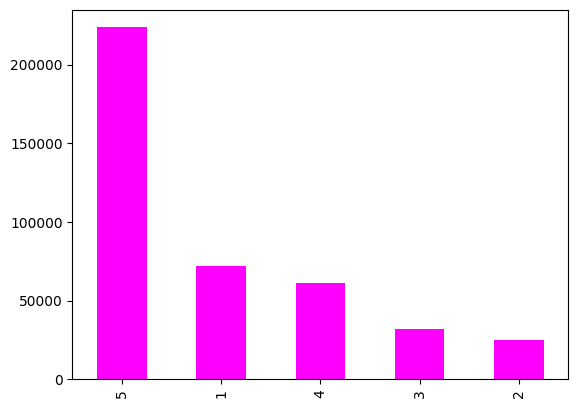

In [9]:
df['Rating'].value_counts().plot.bar(color='Magenta')

In [10]:
def get_sentiment(rating):
    if rating >= 3:
        return 1
    else:
        return 0

df['sentiments'] = df['Rating'].apply(get_sentiment)

the above function will turn the ratings greater than 3 into 1 and remaining as 0

1    316762
0     97078
Name: sentiments, dtype: int64


<AxesSubplot:>

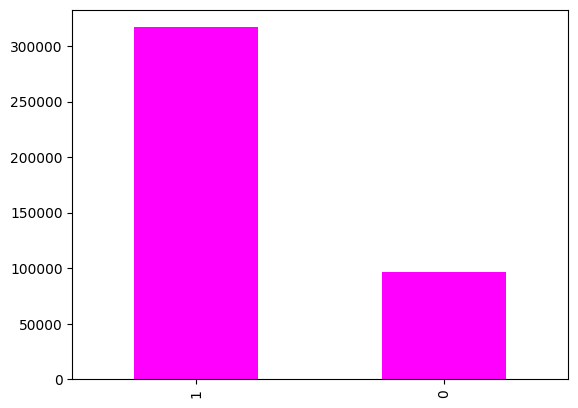

In [11]:
print(df['sentiments'].value_counts())
df['sentiments'].value_counts().plot.bar(color='Magenta')

# Separate Dependent and Idependent Features

In [11]:
# Splitting the data into independent and dependent features
y = df.loc[:, 'sentiments']
X = df.drop('sentiments', axis=1)

# Porter Stemmer
Change the words into its root words

In [12]:
review_msgs = X.copy()
nltk.download('stopwords')
stopwords = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nagayelamarthi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
p=PorterStemmer()
processed_reviews = [ ' '.join([p.stem(word) for word in re.sub('[^a-zA-Z]', ' ', str(review)).lower().split() if word not in stopwords]) for review in review_msgs['Reviews']]

In [14]:
processed_reviews[0]

'feel lucki found use phone us use hard phone line someon upgrad sold one son like old one final fell apart year want upgrad thank seller realli appreci honesti said use phone recommend seller highli would'

# Tokenizing

In [15]:
Max_no_of_words = 50000
length = 150

In [16]:
tokenizer = Tokenizer( num_words= Max_no_of_words, oov_token="<OOV>")
tokenizer.fit_on_texts(processed_reviews)

# Embedding

In [17]:
emb_space = 32

In [18]:
emb_array = tokenizer.texts_to_sequences(processed_reviews)
emb_array = pad_sequences(emb_array, maxlen=length, padding='post', truncating='post')
emb_array = np.array(emb_array) 
emb_array[0]

C:\Users\Nagayelamarthi\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 117, 1543,  224,    4,    2,  185,    4,  220,    2,  382,  358,
        208,  564,    7,  368,    8,  115,    7,  388,  977, 1036,  100,
         39,  208,   82,   73,   21, 1065, 3083,  143,    4,    2,   56,
         73,  372,   13,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [19]:
X_final = np.array(emb_array)
y_final = np.array(y)

In [20]:
X_final.shape, y_final.shape

((413840, 150), (413840,))

# Model Creation

In [21]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Embedding(Max_no_of_words, emb_space, input_length=length))
model.add(Dropout(0.33))
model.add(LSTM(100))
model.add(Dropout(0.33))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 32)           1600000   
                                                                 
 dropout (Dropout)           (None, 150, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2

# Split Data into Train and Test 

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Model Training

In [23]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size=64)

Epoch 1/10
4333/4333 [==============================] - 471s 108ms/step - loss: 0.5483 - accuracy: 0.7657 - val_loss: 0.5450 - val_accuracy: 0.7649
Epoch 2/10
4333/4333 [==============================] - 453s 105ms/step - loss: 0.5425 - accuracy: 0.7668 - val_loss: 0.5445 - val_accuracy: 0.7646
Epoch 3/10
4333/4333 [==============================] - 441s 102ms/step - loss: 0.5281 - accuracy: 0.7701 - val_loss: 0.3430 - val_accuracy: 0.8490
Epoch 4/10
4333/4333 [==============================] - 441s 102ms/step - loss: 0.2598 - accuracy: 0.8959 - val_loss: 0.2159 - val_accuracy: 0.9153
Epoch 5/10
4333/4333 [==============================] - 448s 103ms/step - loss: 0.2089 - accuracy: 0.9203 - val_loss: 0.1987 - val_accuracy: 0.9221
Epoch 6/10
4333/4333 [==============================] - 461s 106ms/step - loss: 0.1860 - accuracy: 0.9299 - val_loss: 0.1849 - val_accuracy: 0.9290
Epoch 7/10
4333/4333 [==============================] - 475s 110ms/step - loss: 0.1705 - accuracy: 0.9364 - val_

# Performance Metrics and Accuracy

In [24]:
y_predict = ((model.predict(X_test)>0.5).astype('int32'))#getting test accuracy

4268/4268 [==============================] - 67s 16ms/step


# **Confusion Matrix**

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict)

array([[ 28151,   4000],
       [  4381, 100036]], dtype=int64)

# **Accuracy Score**

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)

0.9386313045515787

Checking the precision, recall , F1 score to check the performance of the model

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
accuracy = accuracy_score(y_test, y_predict)

# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))

Precision: 0.96
Recall: 0.96
F1 Score: 0.96
Accuracy: 0.94


From the values of above metrics it is clear that the model is performing good